## AI Agents for correcting the questions

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

memory = SqliteSaver.from_conn_string(":memory:")

In [3]:
class AgentState(TypedDict):
    code: str
    check: str
    critique: str
    revision_number: int # keep track of the number revisions
    max_revisions: int # use for criteria

## Installation for Langchain OpenAI

In [4]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [5]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

In [44]:
CHECK_PROMPT = """
You are a Python notebook grader. Your task is to assign a score from 0 to 5 to a student's notebook based on:
1. Code correctness and functionality.
2. Code readability and style.
3. Use of comments and explanations.
4. Structure and flow of the notebook.
5. Originality and creativity.

For the notebook provided below, give a score from 0 to 5, explain your reasoning, and suggest improvements.

Notebook Content:
{notebook_text}

Your Response:
Score: [0-5]
Explanation: [Why this score was assigned]
Suggestions for improvement: [Detailed suggestions]
    """

In [45]:
CRITIQUE_PROMPT = """You are a critique agent tasked with evaluating the grading done by another AI. Below is the original notebook and the grading details.

Notebook Content:
{notebook_text}

Original Grader's Feedback:
{feedback}

Critique the grading:
1. Is the score fair? If not, propose an alternate score.
2. Are the explanations clear and accurate? If not, suggest corrections.
3. Are the suggestions useful? Provide additional suggestions if needed.

Your Response:
Critique: [Fairness, clarity, and accuracy]
Revised Score (if needed): [0-5]
Additional Suggestions: [Improvements on the notebook]
"""

In [46]:
def check_node(state: AgentState):
    check_content = "Here is the suggestion : \n\n".join(state['check'] or [])
    code_content = HumanMessage(content=state['code'])
    
    messages = [
        SystemMessage(content=CHECK_PROMPT.format(notebook_text=code_content)),
        HumanMessage(content=check_content)
    ]

    critique_content = "Here is the critique from suggestion : \n\n".join(state['critique'] or [])
    
    if critique_content:
        critique_message = HumanMessage(content=critique_content)
        messages.append(critique_message)

    response = model.invoke(messages)
    return {"check": response.content}

In [47]:
def reflection_node(state):

    code_content = HumanMessage(content=state['code'])
    messages = [
        SystemMessage(content=CRITIQUE_PROMPT.format(notebook_text=code_content, feedback=state['check'])),
    ]
    response = model.invoke(messages)
    return {"critique": response.content,
            "revision_number": state.get("revision_number", 1) + 1}

In [48]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "score"

In [49]:
builder = StateGraph(AgentState)

builder.add_node("score", check_node)
builder.add_node("reflect", reflection_node)

builder.set_entry_point("score")
builder.add_edge("score", "reflect")

In [50]:
builder.add_conditional_edges(
    "reflect", 
    should_continue, 
    {END: END, "score": "score"}
)

In [51]:
graph = builder.compile(checkpointer=memory)

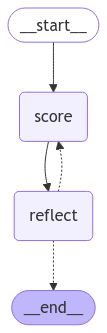

In [52]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [61]:
import nbformat
def extract_code_cells(notebook_path):
    try:
        with open(notebook_path, 'r', encoding='utf-8') as f:
            notebook = nbformat.read(f, as_version=4)

        code_cells = [
            # capture all cell doesn't matter the type
            cell['source'] for cell in notebook['cells']
            # cell['source'] for cell in notebook['cells'] #if cell['cell_type'] == 'code'
        ]

        return code_cells

    except Exception as e:
        print(f'Error reading notebook: {e}')
        return []

In [62]:
import os

os.getcwd()

'c:\\Users\\Sawit\\Desktop\\CheckMate'

In [70]:
notebook_file = "tests/1.ipynb"
code_cells = extract_code_cells(notebook_file)
code_input = "\n".join(code_cells[1:])

In [ ]:
thread = {"configurable": {"thread_id": "1"}}

# visibility 
for s in graph.stream({
    'code': code_input,
    "max_revisions": 2,
    "revision_number": 1,
}, thread):
    print(s)